# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
NDIM = 5 # number of parameters
NBATCH = 128  # minibatch size
NTRAIN = 3000
NEPOCHS = NTRAIN // (NTRAIN // NBATCH) # training epochs
NSAMPLES = 3000 # traing batch size
NWORKERS = 4 # number of cpu workers for dataloader

# Simulator

Given parameters $a, b, c, d, e$ we write the simulator as a sum of functions of position and functions of random variables. The checker pattern is defined 

$$ a \cos(x + 2 b) \cos(y + 2 c). $$

Given $n \sim \mathcal{N}(-0.3, 1)$, the point source random variable is a function of $n$ such that

$$ d \, 10^{e n}. $$

With another noise random variable $noise \sim \mathcal{N}(0, 0.1)$, finally the image in full is

$$ 5 a \cos(x + 2 b) \cos(y + 2 c) + d \, 10^{e n} + noise .$$

In [3]:
# A toy model with a diffuse and point source component

def model(z, sigma = .1):
    z = z.numpy()
    x = np.linspace(-5, 5, 50, 50)
    X, Y = np.meshgrid(x,x)
    diff = np.cos(X+z[1]*2)*np.cos(Y+z[2]*2)*z[0]
    p = np.random.randn(*X.shape)*z[4]-0.3
    psc = 10**p*z[3]
    n = np.random.randn(*X.shape)*sigma
    out = (diff*5 + psc + n)
    return torch.tensor(out).float()

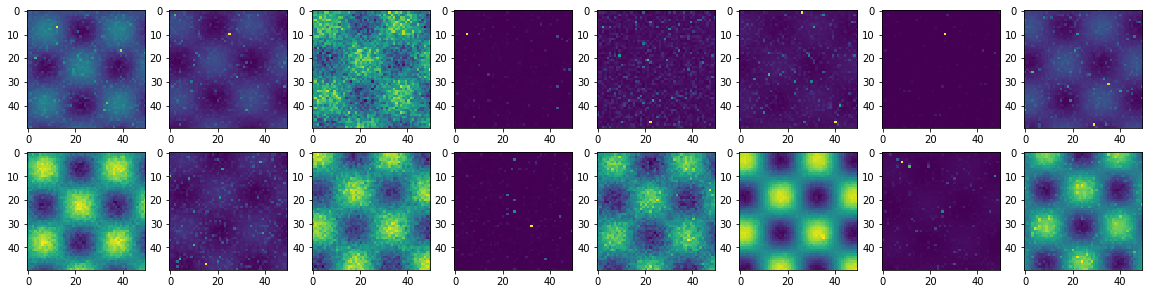

In [4]:
# Random image realizations

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 8, i+1)
    z0 = torch.rand(5)
    x0 = model(z0)
    plt.imshow(x0.numpy())

In [5]:
class Data(torch.utils.data.Dataset):
    def __init__(self, xz):
        super().__init__()
        self.xz = xz

    def __len__(self):
        return len(self.xz)

    def __getitem__(self, idx):
        return self.xz[idx]

In [6]:
# Generate training data
z_cpu = swyft.sample_hypercube(NSAMPLES, NDIM)
xz_cpu = swyft.simulate_xz(model, z_cpu)

xz = Data(xz_cpu)
xz_loader = torch.utils.data.DataLoader(xz, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)

z_valid_cpu = swyft.sample_hypercube(512, NDIM)
xz_valid_cpu = swyft.simulate_xz(model, z_valid_cpu)

xz_valid = Data(xz_valid_cpu)
xz_valid_loader = torch.utils.data.DataLoader(xz_valid, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)

In [7]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [8]:
# Get number of features by evaluating Head network once on target data

ydim = Head()(x0.unsqueeze(0)).shape[1]  # Number of output features per image
print("Number of features:", ydim)

Number of features: 160


## First round
A new network is created and trained based off parameters sampled from the hypercube and simulated. 

The simulation runs until an early stopping patience is reached. The loss function is in [swyft.core.loss_fn](https://github.com/cweniger/swyft/blob/dataloader/swyft/core.py#L104-L158).

In [9]:
# Instantiate network

net = swyft.Network(xdim = ydim, zdim = NDIM, head = Head().to(DEVICE)).to(DEVICE)

In [10]:
# Train!

train_loss, valid_loss = [], []
for i, lr in enumerate([1e-3, 1e-4, 1e-5]):
    print(f'LR Iter {i}', end="\r")
    tl, vl, sd = swyft.train(net, xz_loader, xz_valid_loader, early_stopping_patience = 20, lr = lr, device=DEVICE)
    vl_minimum = min(vl)
    vl_min_idx = vl.index(vl_minimum)
    train_loss.append(tl[:vl_min_idx + 1])
    valid_loss.append(vl[:vl_min_idx + 1])
    net.load_state_dict(sd)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 12.74it/s]


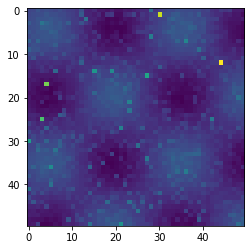

In [11]:
# Generate test image for given parameters, estimate posteriors

z0 = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5])
x0 = model(z0)
plt.imshow(x0.numpy())

x0 = x0.to(DEVICE)
# z = [item.to(DEVICE) for item in swyft.get_z(xz)]
z = torch.stack(swyft.get_z(xz)).to(DEVICE)
post = swyft.estimate_lnL(net, x0, z)

z_valid = torch.stack(swyft.get_z(xz_valid)).to(DEVICE)
post_valid = swyft.estimate_lnL(net, x0, z_valid, n_batch=129)

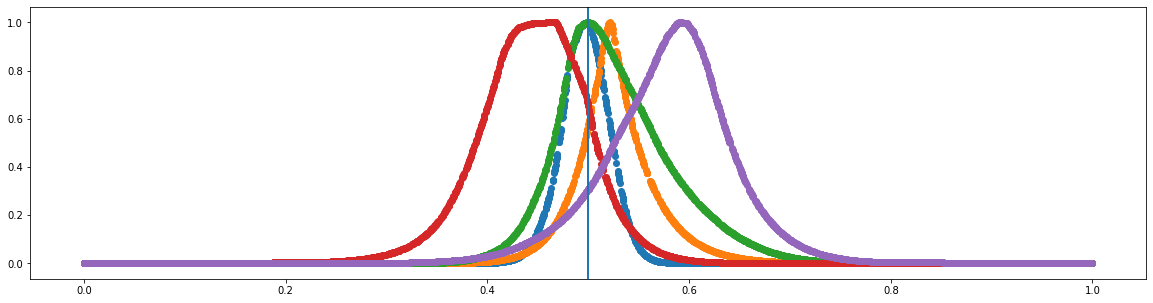

In [12]:
# Likelihood (posteriors because prior was uniform) evaluated on a validation set

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    zp = post[i]['z']
    lnLp = np.exp(post[i]['lnL'])
    plt.axvline(z0[i])
    plt.scatter(zp, lnLp)
#plt.ylim([-10, 0])

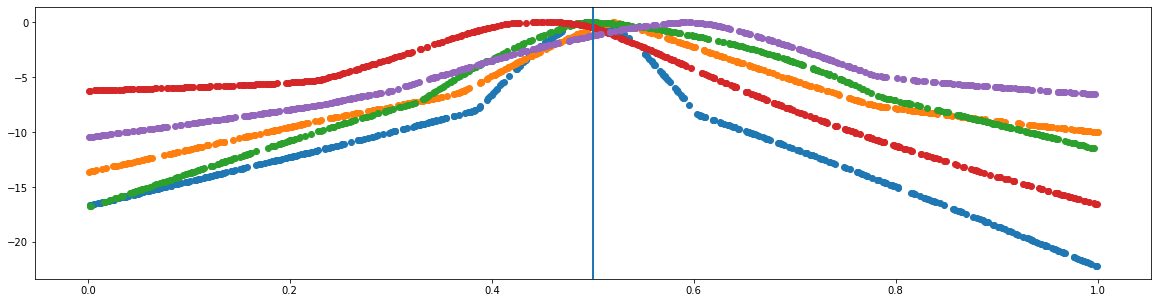

In [13]:
# Log Likelihood (posteriors because prior was uniform) evaluated on a validation set

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    zp_valid = post_valid[i]['z']
    lnLp_valid = post_valid[i]['lnL']
    plt.axvline(z0[i])
    plt.scatter(zp_valid, lnLp_valid)

# Second Round

Here we generate training data from a uniform prior but on smaller support. Implemented in [swyft.iter_sample_z](https://github.com/cweniger/swyft/blob/dataloader/swyft/core.py#L384-L416). The way we determine if something is in the support, given threshold $T$, a sample lies within the support when sample $z \sim U(\Omega)$ satisfies $e^{f_{\phi}(z, x)} > T$.

The effects of this are small, but visible, in the log-likelihood(posterior) plot. Before I implemented early stopping, the effect was more drastic but the sample efficiency was really bad.

Note that sample reuse is not yet implemented. Simple rejection sampling is possible, better would be rejection sampling with a "cache" where the "hit" is determined by some rejection sampling from points in likelihood-isolines as determined by the previos likelihood estimator.

In [14]:
# Generate training data
z2_cpu = swyft.iter_sample_z(NSAMPLES, NDIM, net, x0, threshold = 1e-8)
xz2_cpu = swyft.simulate_xz(model, z2_cpu)

xz2 = Data(xz2_cpu)
xz2_loader = torch.utils.data.DataLoader(xz2, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)

z2_valid_cpu = swyft.iter_sample_z(513, NDIM, net, x0, threshold = 1e-8)
xz2_valid_cpu = swyft.simulate_xz(model, z2_valid_cpu)

xz2_valid = Data(xz2_valid_cpu)
xz2_valid_loader = torch.utils.data.DataLoader(xz2_valid, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)

In [15]:
# Instantiate network
net2 = swyft.Network(xdim = ydim, zdim = NDIM, head = Head().to(DEVICE)).to(DEVICE)

# Train!
train_loss, valid_loss = [], []
for i, lr in enumerate([1e-3, 1e-4, 1e-5]):
    print(f'LR Iter {i}', end="\r")
    tl, vl, sd = swyft.train(net2, xz2_loader, xz2_valid_loader, early_stopping_patience = 20, lr = lr, device=DEVICE)
    vl_minimum = min(vl)
    vl_min_idx = vl.index(vl_minimum)
    train_loss.append(tl[:vl_min_idx + 1])
    valid_loss.append(vl[:vl_min_idx + 1])
    net.load_state_dict(sd)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 11.82it/s]


(0, 1)

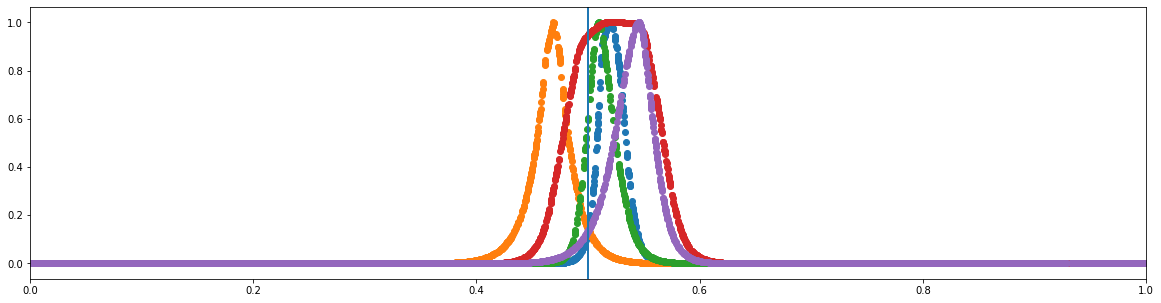

In [16]:
# Likelihood (posteriors because prior was uniform) evaluated on a validation set

z2 = [item.to(DEVICE) for item in swyft.get_z(xz2)]
post2 = swyft.estimate_lnL(net2, x0, z2)

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    zp = post2[i]['z']
    lnLp = np.exp(post2[i]['lnL'])
    plt.axvline(z0[i])
    plt.scatter(zp, lnLp)
plt.xlim([0, 1])

(0, 1)

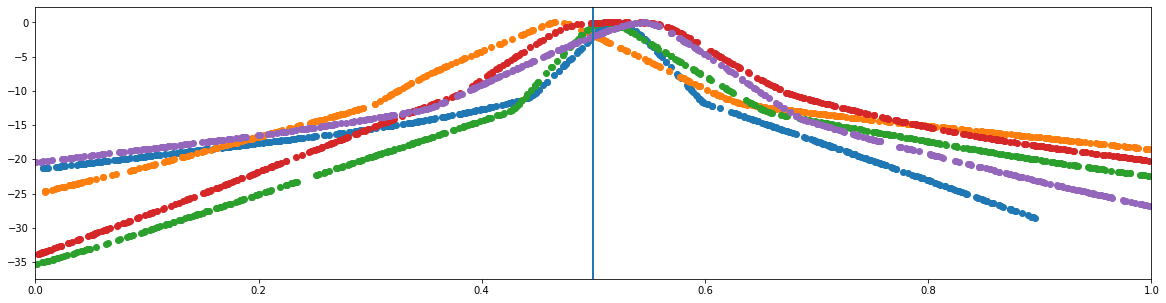

In [17]:
# Log Likelihood (posteriors because prior was uniform) evaluated on a validation set

z2_valid = [item.to(DEVICE) for item in swyft.get_z(xz2_valid)]
post2_valid = swyft.estimate_lnL(net2, x0, z2_valid, n_batch=65)

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    zp = post2_valid[i]['z']
    lnLp = post2_valid[i]['lnL']
    plt.axvline(z0[i])
    plt.scatter(zp, lnLp)
plt.xlim([0, 1])

### Restricted support

Notice that the support of the samples (blue, red, green) is slightly smaller. This effect was more pronounced on further training but the shape of the posteriors was not very different with further training.

Below are some samples taken from this posterior and simulated. Checkerboard patter is fairly close but the number of stars has a wide variance still.

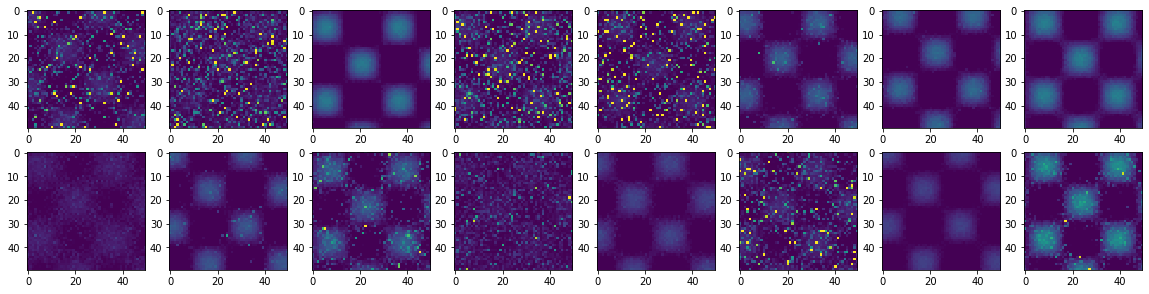

In [18]:
plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 8, i+1)
    plt.imshow(model(z2[i].cpu()).numpy(), vmin = 0, vmax = 10)

# Combinations using 1st round data

In [ ]:
# Instantiate network
combinations = [[0, 1], [0, 2], [0, 3], [0, 4], [1, 2]]
net_combo = swyft.Network(xdim = ydim, zdim = NDIM, pdim=len(combinations[0]), head = Head().to(DEVICE)).to(DEVICE)

# Train!
train_loss, valid_loss = [], []
for i, lr in enumerate([1e-3, 1e-4, 1e-5]):
    print(f'LR Iter {i}', end="\r")
    tl, vl, sd = swyft.train(
        net_combo, 
        xz_loader, 
        xz_valid_loader, 
        early_stopping_patience = 5, 
        lr = lr, 
        combinations=combinations,
        device=DEVICE
    )
    vl_minimum = min(vl)
    vl_min_idx = vl.index(vl_minimum)
    train_loss.append(tl[:vl_min_idx + 1])
    valid_loss.append(vl[:vl_min_idx + 1])
    net_combo.load_state_dict(sd)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.37it/s]

In [ ]:
# Log Likelihood (posteriors because prior was uniform) evaluated on a validation set
z_valid = [item.to(DEVICE) for item in swyft.get_z(xz_valid)]
post_valid = swyft.estimate_lnL(net_combo, x0, z2_valid, n_batch=65, combinations=combinations)

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    plt.figure(figsize = (5, 5))
    xx = post_valid[i]['lnL']
    zz = post_valid[i]['z']
    plt.scatter(zz[:, 0], zz[:, 1], marker='.', color='k')
    plt.tricontour(zz[:, 0], zz[:, 1], (xx - xx.max())*2, levels = [-9, -4, -1])
    plt.xlim([0, 1])
    plt.ylim([0, 1])